In [ ]:
# !unzip /content/maskdetection.zip

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def to_grayscale_then_rgb(image):
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.grayscale_to_rgb(image)
    return image

train_datagen = ImageDataGenerator(rescale = 1./ 255, #데이터에 제공된 값을 곱함
                                   rotation_range = 20, # 무작위 회전에 대한 도(ㅇ) 단위 범위
                                   width_shift_range = 0.1, #이미지를 수평으로 임의로 이동(전체 너비의 대칭)
                                   height_shift_range = 0.1, #이미지를 수직으로 임의로 이동(전체 높이의 대칭)
                                   zoom_range = 0.05, # 무작위 확대/축소 범위
                                   preprocessing_function=to_grayscale_then_rgb,
                                   horizontal_flip = True, #입력을 수평으로 랜덤하게 뒤집음
                                   fill_mode = 'reflect') #One of {“constant”, “nearest”, “reflect” or “wrap”}, “nearest”가 기본
val_datagen = ImageDataGenerator(rescale=1./ 255)
test_datagen = ImageDataGenerator(rescale=1./ 255)

### Train, Valid, Test 분할

In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split

# 원본 데이터 경로
data_dir = '/content/face_maskdetection'
with_mask_dir = os.path.join(data_dir, 'with_mask')
without_mask_dir = os.path.join(data_dir, 'without_mask')

# 목적지 디렉토리 설정
base_dir = '/content/facemask_split'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

# 서브 디렉토리 설정
train_with_mask_dir = os.path.join(train_dir, 'with_mask')
train_without_mask_dir = os.path.join(train_dir, 'without_mask')
valid_with_mask_dir = os.path.join(valid_dir, 'with_mask')
valid_without_mask_dir = os.path.join(valid_dir, 'without_mask')
test_with_mask_dir = os.path.join(test_dir, 'with_mask')
test_without_mask_dir = os.path.join(test_dir, 'without_mask')

# 디렉토리 생성
os.makedirs(train_with_mask_dir, exist_ok=True)
os.makedirs(train_without_mask_dir, exist_ok=True)
os.makedirs(valid_with_mask_dir, exist_ok=True)
os.makedirs(valid_without_mask_dir, exist_ok=True)
os.makedirs(test_with_mask_dir, exist_ok=True)
os.makedirs(test_without_mask_dir, exist_ok=True)

# 파일 리스트
with_mask_files = os.listdir(with_mask_dir)
without_mask_files = os.listdir(without_mask_dir)

# 파일 분할
train_with_mask, test_with_mask = train_test_split(with_mask_files, test_size=0.3, random_state=11)
valid_with_mask, test_with_mask = train_test_split(test_with_mask, test_size=1/3, random_state=11)

train_without_mask, test_without_mask = train_test_split(without_mask_files, test_size=0.3, random_state=11)
valid_without_mask, test_without_mask = train_test_split(test_without_mask, test_size=1/3, random_state=11)

# 파일 복사 함수
def copy_files(file_list, src_dir, dest_dir):
    for file_name in file_list:
        shutil.copy(os.path.join(src_dir, file_name), dest_dir)

# 파일 복사
copy_files(train_with_mask, with_mask_dir, train_with_mask_dir)
copy_files(valid_with_mask, with_mask_dir, valid_with_mask_dir)
copy_files(test_with_mask, with_mask_dir, test_with_mask_dir)

copy_files(train_without_mask, without_mask_dir, train_without_mask_dir)
copy_files(valid_without_mask, without_mask_dir, valid_without_mask_dir)
copy_files(test_without_mask, without_mask_dir, test_without_mask_dir)


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# 데이터 증강 및 로딩
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 963 images belonging to 2 classes.
Found 275 images belonging to 2 classes.
Found 138 images belonging to 2 classes.


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

drop_rate = 0.2

base_model = tf.keras.applications.VGG16(input_shape=(150, 150, 3), include_top=False, weights='imagenet')

def build_cnn_model():
  model = keras.Sequential()
  model.add(base_model)
  model.add(layers.Flatten())
  model.add(layers.Dense(1024, activation='relu'))
  model.add(layers.Dropout(drop_rate))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
  return model

In [5]:
model = build_cnn_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 1024)              8389632   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 1)                 513       
                                                                 
Total params: 23629633 (90.14 MB)
Trainable params: 2362

In [6]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.001)

model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['acc'])

In [7]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

EPOCHS = 50
BATCH_SIZE =64
checkpoint_filepath = 'best_weights.hdf5'
# ModelCheckpoint 콜백 설정
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(train_generator,
                    epochs = EPOCHS,
                    batch_size = BATCH_SIZE,
                    validation_data=valid_generator,
                    callbacks=[early_stopping, model_checkpoint])


Epoch 1/50
31/31 [==============================] - ETA: 0s - loss: 1.0390 - acc: 0.5306
Epoch 1: val_loss improved from inf to 0.68227, saving model to best_weights.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 22s 259ms/step - loss: 1.0390 - acc: 0.5306 - val_loss: 0.6823 - val_acc: 0.5345
Epoch 2/50
31/31 [==============================] - ETA: 0s - loss: 0.5624 - acc: 0.7217
Epoch 2: val_loss improved from 0.68227 to 0.15923, saving model to best_weights.hdf5
31/31 [==============================] - 5s 149ms/step - loss: 0.5624 - acc: 0.7217 - val_loss: 0.1592 - val_acc: 0.9491
Epoch 3/50
31/31 [==============================] - ETA: 0s - loss: 0.1225 - acc: 0.9637
Epoch 3: val_loss improved from 0.15923 to 0.11580, saving model to best_weights.hdf5
31/31 [==============================] - 5s 145ms/step - loss: 0.1225 - acc: 0.9637 - val_loss: 0.1158 - val_acc: 0.9636
Epoch 4/50
31/31 [==============================] - ETA: 0s - loss: 0.2110 - acc: 0.9335
Epoch 4: val_loss improved from 0.11580 to 0.03155, saving model to best_weights.hdf5
31/31 [==============================] - 5s 157ms/step - loss: 0.2110 - acc: 0.9335 - val_loss: 0.0316 - val_ac

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize = (10,5))

  plt.subplot(1,2,1)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(hist['epoch'], hist['loss'], label='Train Loss')
  plt.plot(hist['epoch'], hist['val_loss'], label='Val Loss')
  plt.legend()

  plt.subplot(1,2,2)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(hist['epoch'], hist['acc'], label='Train Accuracy')
  plt.plot(hist['epoch'], hist['val_acc'], label='Val Accuracy')
  plt.legend()

plt.show()

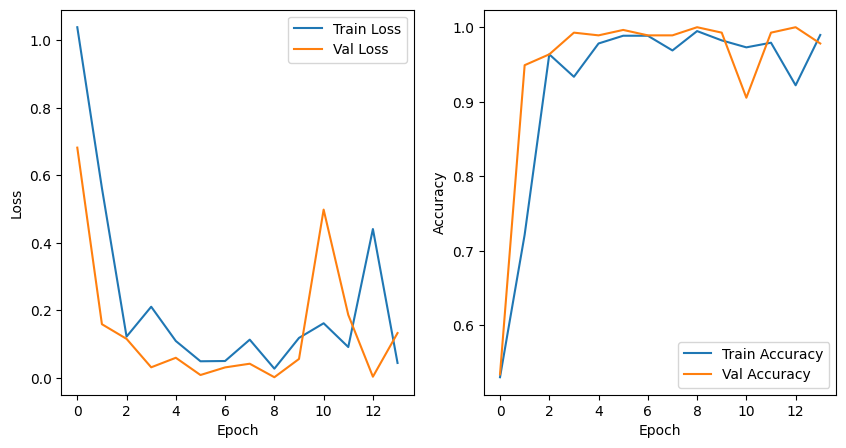

In [9]:
plot_history(history)

In [10]:
# 가장 좋은 가중치 로드
model.load_weights(checkpoint_filepath)
# 예측 수행
predictions = model.predict(test_generator)


5/5 [==============================] - 1s 298ms/step


In [11]:
test_loss, test_acc = model.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)


5/5 [==============================] - 0s 39ms/step - loss: 0.0011 - acc: 1.0000
Test loss: 0.001124984584748745
Test accuracy: 1.0


In [12]:
import numpy as np
y_pred_argmax = np.argmax(predictions, axis = 1)
y_pred_argmax[:10]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

1/1 [==============================] - 0s 157ms/step


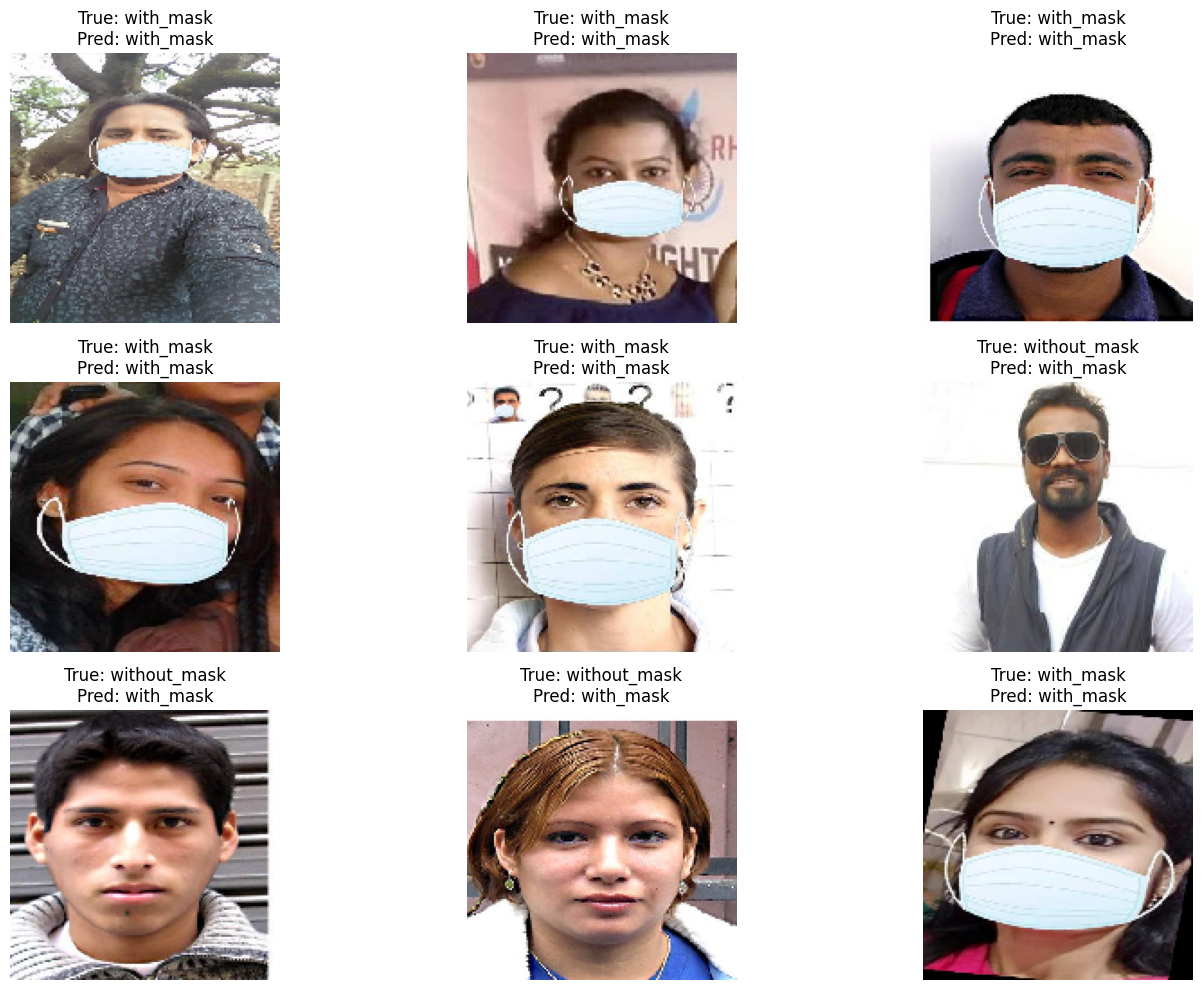

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# test_generator에서 한 배치의 이미지와 레이블 가져오기
images, labels = next(test_generator)

# 예측 수행
predictions = model.predict(images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = labels.astype(int)  # 정수형으로 변환

# 클래스 레이블 가져오기
class_labels = list(test_generator.class_indices.keys())

# 이미지와 예측 레이블, 실제 레이블을 시각화하는 함수
def plot_predictions(images, true_labels, predicted_labels, class_labels):
    plt.figure(figsize=(15, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {class_labels[int(true_labels[i])]}\nPred: {class_labels[int(predicted_labels[i])]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# 시각화
plot_predictions(images, true_classes, predicted_classes, class_labels)
